In [10]:
import pandas as pd

file_path = r"D:\village\Titanic\archive\tested.csv"  # your raw CSV
df = pd.read_csv(file_path)

# Shape and columns
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())

# Data types and info
print("\nInfo:")
print(df.info())

# Missing values
print("\nMissing values:")
print(df.isnull().sum())

# Target distribution
print("\nSurvived value counts:")
print(df['Survived'].value_counts())

# First few rows
print("\nFirst 5 rows:")
print(df.head())


Shape: (418, 12)

Columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB
None

Missing values:
PassengerId      0
Survived         0
Pclass           0
Name          

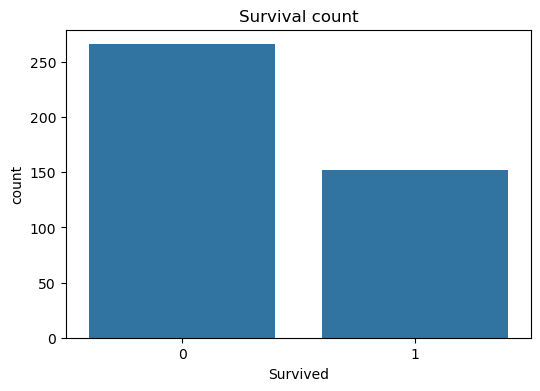

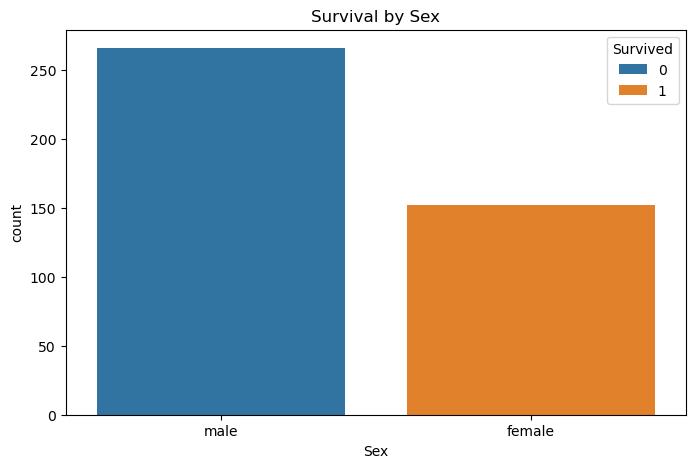

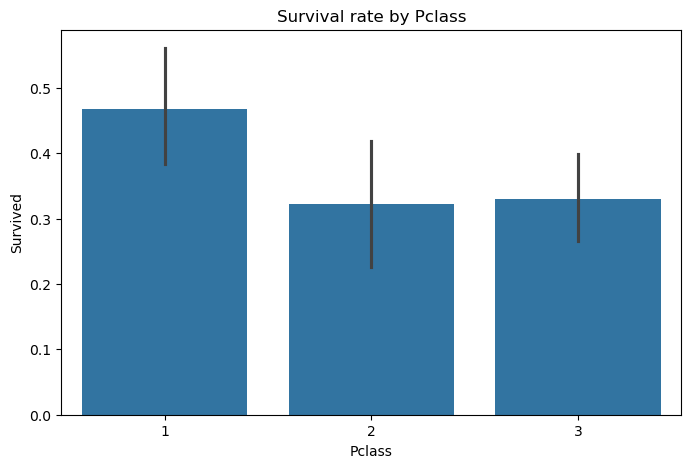

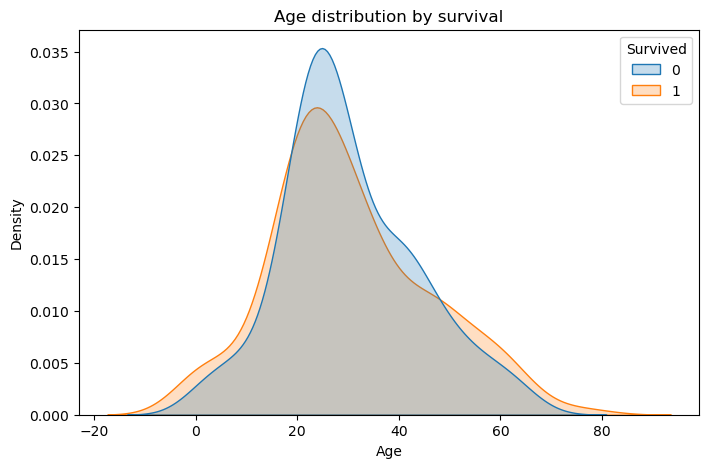

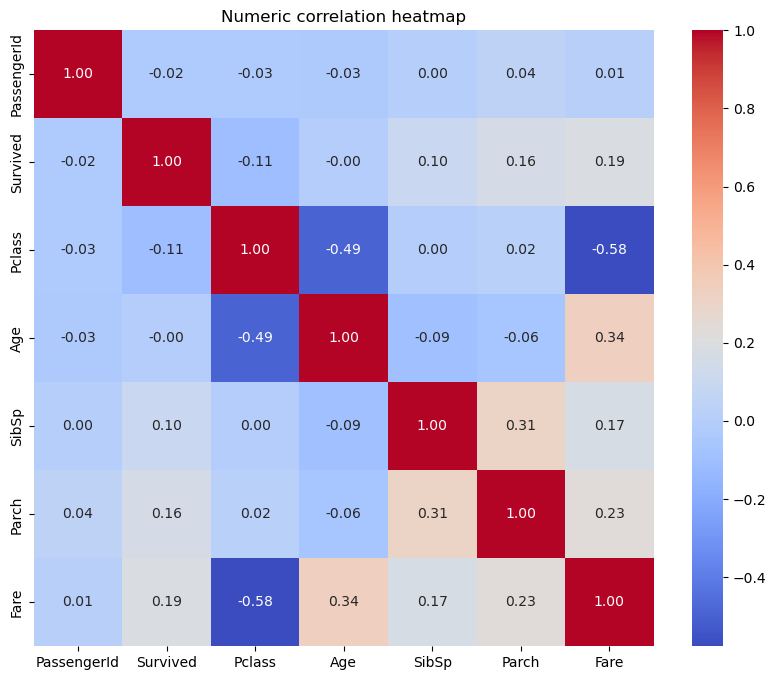

In [11]:
# Step 2: eda.py
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# assume `df` loaded as above
plt.figure(figsize=(6,4))
sns.countplot(x="Survived", data=df)
plt.title("Survival count")
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x="Sex", hue="Survived", data=df)
plt.title("Survival by Sex")
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x="Pclass", y="Survived", data=df, estimator=np.mean)
plt.title("Survival rate by Pclass")
plt.show()

plt.figure(figsize=(8,5))
sns.kdeplot(data=df, x="Age", hue="Survived", fill=True, common_norm=False)
plt.title("Age distribution by survival")
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Numeric correlation heatmap")
plt.show()


In [12]:
import pandas as pd
import numpy as np
import re

# -------------------------
# 1. Feature Engineering
# -------------------------
if 'Name' in df.columns:
    def extract_title(name):
        if pd.isna(name):
            return "Unknown"
        m = re.search(r',\s*([^\.]+)\.', str(name))
        return m.group(1).strip() if m else "Unknown"

    df['Title'] = df['Name'].apply(extract_title)

    # Map rare/alternative titles
    title_map = {
        'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
        'Lady': 'Royal', 'Countess': 'Royal', 'Sir': 'Royal',
        'Don': 'Rare', 'Dona': 'Rare', 'Jonkheer': 'Rare',
        'Capt': 'Rare', 'Col': 'Rare', 'Major': 'Rare', 'Rev': 'Rare', 'Dr': 'Rare'
    }
    df['Title'] = df['Title'].replace(title_map)

    # Drop 'Name' after feature extraction
    df.drop(['Name'], axis=1, inplace=True)
else:
    print("Column 'Name' not found. Skipping Title extraction.")

# -------------------------
# 2. Family features
# -------------------------
df['FamilySize'] = df['SibSp'].fillna(0) + df['Parch'].fillna(0) + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

# -------------------------
# 3. Fare per person
# -------------------------
df['FarePerPerson'] = df['Fare'].fillna(0) / df['FamilySize']

# -------------------------
# 4. Deck from Cabin
# -------------------------
if 'Cabin' in df.columns:
    df['Deck'] = df['Cabin'].fillna('Unknown').astype(str).map(lambda x: x[0] if x != 'Unknown' else 'Unknown')
    df.drop(['Cabin'], axis=1, inplace=True)
else:
    print("Column 'Cabin' not found. Skipping Deck extraction.")

# -------------------------
# 5. Handle missing numeric values
# -------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

# -------------------------
# 6. Handle missing categorical values
# -------------------------
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

print("Preprocessing & feature engineering complete.")
print(df.head())


Preprocessing & feature engineering complete.
   PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch   Ticket  \
0          892         0       3    male  34.5      0      0   330911   
1          893         1       3  female  47.0      1      0   363272   
2          894         0       2    male  62.0      0      0   240276   
3          895         0       3    male  27.0      0      0   315154   
4          896         1       3  female  22.0      1      1  3101298   

      Fare Embarked Title  FamilySize  IsAlone  FarePerPerson     Deck  
0   7.8292        Q    Mr           1        1       7.829200  Unknown  
1   7.0000        S   Mrs           2        0       3.500000  Unknown  
2   9.6875        Q    Mr           1        1       9.687500  Unknown  
3   8.6625        S    Mr           1        1       8.662500  Unknown  
4  12.2875        S   Mrs           3        0       4.095833  Unknown  


In [13]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import pickle
import os

PROCESSED_DIR = "data/processed"
os.makedirs(PROCESSED_DIR, exist_ok=True)

# -------------------------
# Basic fills
# -------------------------
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df['Fare'] = df['Fare'].fillna(df['Fare'].median())

# -------------------------
# Label encode categorical columns
# -------------------------
le_map = {}
for col in ['Sex','Embarked','Title','Deck']:
    if col in df.columns:  # safe check
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        le_map[col] = le
        # Save LabelEncoder as .pkl
        with open(f"{PROCESSED_DIR}/{col}_labelencoder.pkl", "wb") as f:
            pickle.dump(le, f)

# -------------------------
# Numeric columns for imputation
# -------------------------
numeric_cols = ['Age','Fare','SibSp','Parch','FamilySize','FarePerPerson']

# Include some categorical encodings to improve KNN imputation
imputer_cols = [c for c in numeric_cols if c in df.columns] + \
               [c for c in ['Sex','Pclass','Embarked'] if c in df.columns]

imputer = KNNImputer(n_neighbors=5)
imputed = imputer.fit_transform(df[imputer_cols])
imputed_df = pd.DataFrame(imputed, columns=imputer_cols, index=df.index)

# Update numeric columns in df
for c in numeric_cols:
    if c in df.columns:
        df[c] = imputed_df[c]

# Save KNNImputer as .pkl
with open(f"{PROCESSED_DIR}/knn_imputer.pkl", "wb") as f:
    pickle.dump(imputer, f)

print("Encoding & imputation done using .pkl files.")


Encoding & imputation done using .pkl files.


In [14]:
# scale_and_save.py
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle
import json
import os

PROCESSED_DIR = "data/processed"
os.makedirs(PROCESSED_DIR, exist_ok=True)

# -------------------------
# Define columns safely
# -------------------------
numeric_cols = [c for c in ['Age','Fare','SibSp','Parch','FamilySize','FarePerPerson'] if c in df.columns]
cat_cols = [c for c in ['Pclass','Sex','Embarked','Title','Deck','IsAlone'] if c in df.columns]

# -------------------------
# Scale numeric columns
# -------------------------
if numeric_cols:  # check if there are numeric columns
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    # Save scaler as .pkl
    with open(f"{PROCESSED_DIR}/scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)
    print("Scaler saved as .pkl")

# -------------------------
# Save features list
# -------------------------
features = numeric_cols + cat_cols
with open(f"{PROCESSED_DIR}/features.json", "w") as f:
    json.dump(features, f)

print("Feature list saved to features.json")
print("Scaling complete.")


Scaler saved as .pkl
Feature list saved to features.json
Scaling complete.


In [15]:
# split_save.py
import os
import pandas as pd
from sklearn.model_selection import train_test_split

PROCESSED_DIR = "data/archive"
os.makedirs(PROCESSED_DIR, exist_ok=True)

# -------------------------
# Ensure features exist in df
# -------------------------
features_existing = [col for col in features if col in df.columns]

# -------------------------
# Prepare X and y
# -------------------------
X = df[features_existing]
y = df['Survived']  # make sure target exists

# -------------------------
# Train-test split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -------------------------
# Save datasets
# -------------------------
X_train.to_csv(f"{PROCESSED_DIR}/X_train.csv", index=False)
X_test.to_csv(f"{PROCESSED_DIR}/X_test.csv", index=False)
y_train.to_csv(f"{PROCESSED_DIR}/y_train.csv", index=False)
y_test.to_csv(f"{PROCESSED_DIR}/y_test.csv", index=False)

# Save full processed DataFrame as parquet for efficient storage
df.to_parquet(f"{PROCESSED_DIR}/titanic_processed.parquet", index=False)

# -------------------------
# Confirmation
# -------------------------
print("Saved processed datasets and artifacts to", PROCESSED_DIR)
print("Shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


Saved processed datasets and artifacts to data/archive
Shapes:
X_train: (334, 12)
X_test: (84, 12)
y_train: (334,)
y_test: (84,)
